In [1]:
# Install PySpark
!pip install pyspark

# Install PyDrive
!pip install -U -q PyDrive

# Install OpenJDK 8 (Java Development Kit) headless version
!apt install openjdk-8-jdk-headless -qq

# Set the JAVA_HOME environment variable to the OpenJDK 8 path
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u392-ga-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [2]:
# Import necessary libraries from PyDrive and Google Colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate user and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download 'data.txt' from Google Drive
id1 = '1E-voIV2ctU4Brw022Na8RHVVRGOoNkO1'
downloaded = drive.CreateFile({'id': id1})
downloaded.GetContentFile('data.txt')

# Download 'c1.txt' from Google Drive
id2 = '1yXNlZWMqUcAwDScBrkFChOHJwR1FZXmI'
downloaded = drive.CreateFile({'id': id2})
downloaded.GetContentFile('c1.txt')

# Download 'c2.txt' from Google Drive
id3 = '1vfovle9DgaeK0LnbQTH0j7kRaJjsvLtb'
downloaded = drive.CreateFile({'id': id3})
downloaded.GetContentFile('c2.txt')

In [3]:
# Import necessary libraries for data manipulation, analysis, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import PySpark libraries for distributed data processing
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Create the Spark Session
spark = SparkSession.builder.getOrCreate()

# Create the Spark Context
sc = spark.sparkContext

1a)

A plot of cost vs. iteration for two initialization strategies for 1(a).

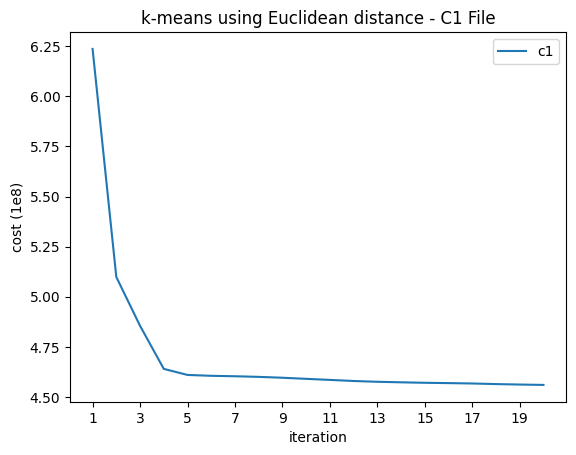

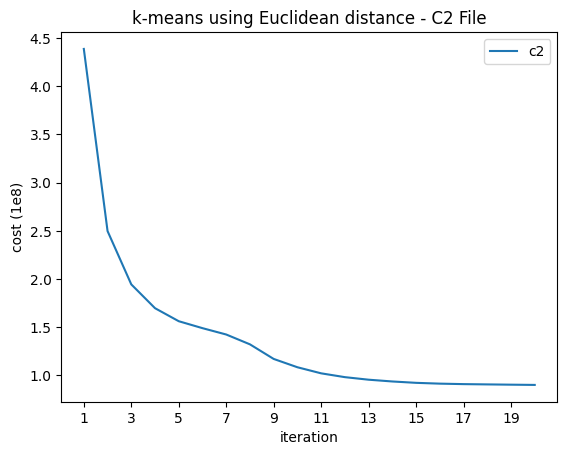

In [4]:
# Define a function to parse a space-separated vector from a text line
def parseVector(line):
    return np.array([float(x) for x in line.split(" ")])

# Define a function to find the closest centroid for a point using Euclidean or Manhattan distance
def closestPoint(p, centroids, method='d2'):
    bestIndex = -1
    minDistance = float("+inf")
    for i in range(len(centroids)):
        if method == 'd2':
            tempDistance = np.sum((p - centroids[i]) ** 2)
        elif method == 'd1':
            tempDistance = np.sum(np.abs(p - centroids[i]))

        if tempDistance < minDistance:
            minDistance = tempDistance
            bestIndex = i

    return bestIndex, minDistance

# Read data from 'data.txt' and convert it to an RDD of vectors
data = spark.read.text('data.txt').rdd.map(lambda x: x[0]).map(parseVector)

# Load initial centroids from 'c1.txt' and 'c2.txt'
initialCentroids1 = np.loadtxt('c1.txt', delimiter=' ')
initialCentroids2 = np.loadtxt('c2.txt', delimiter=' ')

# Set the maximum number of iterations
MAX_ITER = 20

# Initialize centroids for each cluster
centroids1 = initialCentroids1.copy()
centroids2 = initialCentroids2.copy()

# Lists to store errors for each iteration
errorCluster1 = []
errorCluster2 = []

# K-means clustering for cluster 1
for iteration in range(MAX_ITER):
    # Find the closest centroid for each point and calculate new centroids
    closest = data.map(lambda p: (closestPoint(p, centroids1, 'd2')[0], (p, 1, closestPoint(p, centroids1, 'd2')[1])))
    pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newCentroids = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    # Calculate and store the total error for the current iteration
    totalError = np.sum(np.array(list(x[1][2] for x in closest.collect())))
    errorCluster1.append(totalError)

    # Update centroids with new values
    for (i, p) in newCentroids:
        centroids1[i] = p

# Lists to store errors for each iteration
errorCluster2 = []

# K-means clustering for cluster 2
for iteration in range(MAX_ITER):
    # Find the closest centroid for each point and calculate new centroids
    closest = data.map(lambda p: (closestPoint(p, centroids2, 'd2')[0], (p, 1, closestPoint(p, centroids2, 'd2')[1])))
    pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newCentroids = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    # Calculate and store the total error for the current iteration
    totalError = np.sum(np.array(list(x[1][2] for x in closest.collect())))
    errorCluster2.append(totalError)

    # Update centroids with new values
    for (i, p) in newCentroids:
        centroids2[i] = p

# Plot for c1
plt.figure()
plt.plot(list(range(1, 21)), np.array(errorCluster1) / 100000000, label='c1')
plt.xticks(list(range(1, 21, 2)))
plt.xlabel('iteration')
plt.ylabel('cost (1e8)')
plt.title('k-means using Euclidean distance - C1 File')
plt.legend(['c1'])
plt.show()

# Plot for c2
plt.figure()
plt.plot(list(range(1, 21)), np.array(errorCluster2) / 100000000, label='c2')
plt.xticks(list(range(1, 21, 2)))
plt.xlabel('iteration')
plt.ylabel('cost (1e8)')
plt.title('k-means using Euclidean distance - C2 File')
plt.legend(['c2'])
plt.show()

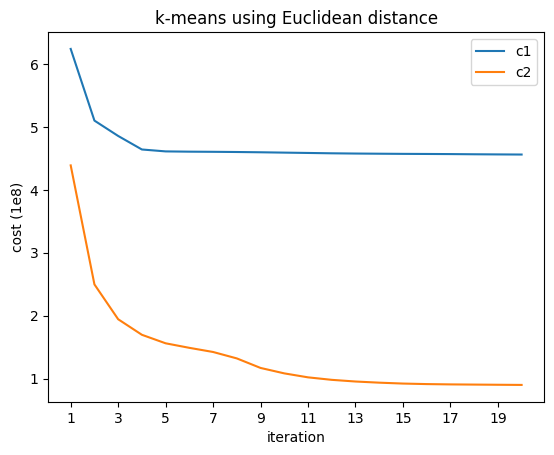

In [5]:
# Plot the results for k-means using Euclidean distance for both c1 and c2 clusters
plt.figure()
plt.plot(list(range(1, 21)), np.array(errorCluster1) / 100000000, label ='c1')
plt.plot(list(range(1, 21)), np.array(errorCluster2) / 100000000, label = 'c2')
plt.xticks(list(range(1, 21, 2)))
plt.xlabel('iteration')
plt.ylabel('cost (1e8)')
plt.title('k-means using Euclidean distance')
plt.legend(['c1', 'c2'])


plt.show()

Percentage improvement values and your explanation for 1(a).

In [6]:
# Print the percentage change in errors for both clusters
percentageChangeCluster1 = (errorCluster1[0] - errorCluster1[10]) / errorCluster1[0]
percentageChangeCluster2 = (errorCluster2[0] - errorCluster2[10]) / errorCluster2[0]
print("The percentage change in c1 by using Euclidean distance is: {}".format(percentageChangeCluster1))
print("The percentage change in c2 by using Euclidean distance is: {}".format(percentageChangeCluster2))

The percentage change in c1 by using Euclidean distance is: 0.2648391714456054
The percentage change in c2 by using Euclidean distance is: 0.7669795594605942


1b)

A plot of cost vs. iteration for two initialization strategies for 1(b).

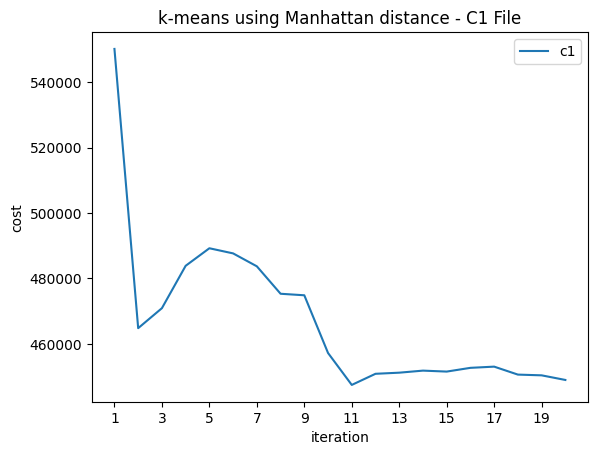

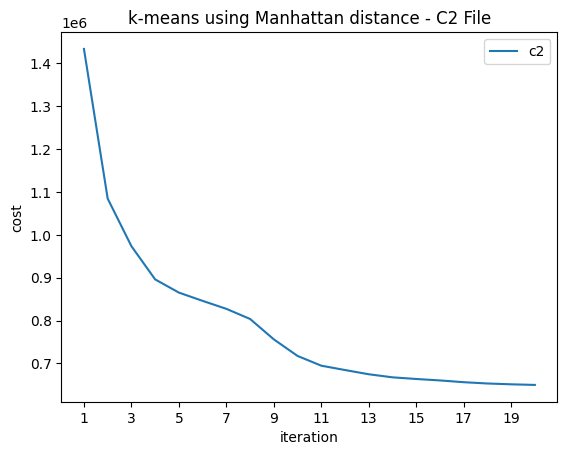

In [7]:
# Read data from 'data.txt' and convert it to an RDD of vectors
data = spark.read.text('data.txt').rdd.map(lambda x: x[0]).map(parseVector)

# Load initial centroids from 'c1.txt' and 'c2.txt'
initialCentroids1 = np.loadtxt('c1.txt', delimiter=' ')
initialCentroids2 = np.loadtxt('c2.txt', delimiter=' ')

# Set the maximum number of iterations
MAX_ITER = 20

# Initialize centroids for each cluster
centroids1 = initialCentroids1.copy()
centroids2 = initialCentroids2.copy()

# Lists to store errors for each iteration
errorCluster1Manhattan = []
errorCluster2Manhattan = []

# K-means clustering for cluster 1 using Manhattan distance
for iteration in range(MAX_ITER):
    # Find the closest centroid for each point and calculate new centroids
    closest = data.map(lambda p: (closestPoint(p, centroids1, 'd1')[0], (p, 1, closestPoint(p, centroids1, 'd1')[1])))
    pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newCentroids = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    # Calculate and store the total error for the current iteration
    totalError = np.sum(np.array(list(x[1][2] for x in closest.collect())))
    errorCluster1Manhattan.append(totalError)

    # Update centroids with new values
    for (i, p) in newCentroids:
        centroids1[i] = p

# Lists to store errors for each iteration
errorCluster2Manhattan = []

# K-means clustering for cluster 2 using Manhattan distance
for iteration in range(MAX_ITER):
    # Find the closest centroid for each point and calculate new centroids
    closest = data.map(lambda p: (closestPoint(p, centroids2, 'd1')[0], (p, 1, closestPoint(p, centroids2, 'd1')[1])))
    pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newCentroids = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    # Calculate and store the total error for the current iteration
    totalError = np.sum(np.array(list(x[1][2] for x in closest.collect())))
    errorCluster2Manhattan.append(totalError)

    # Update centroids with new values
    for (i, p) in newCentroids:
        centroids2[i] = p

# Plot for c1 using Manhattan distance
plt.figure()
plt.plot(list(range(1, 21)), np.array(errorCluster1Manhattan), label='c1')
plt.xticks(list(range(1, 21, 2)))
plt.xlabel('iteration')
plt.ylabel('cost')
plt.legend(['c1'])
plt.title('k-means using Manhattan distance - C1 File')
plt.show()

# Plot for c2 using Manhattan distance
plt.figure()
plt.plot(list(range(1, 21)), np.array(errorCluster2Manhattan), label='c2')
plt.xticks(list(range(1, 21, 2)))
plt.xlabel('iteration')
plt.ylabel('cost')
plt.legend(['c2'])
plt.title('k-means using Manhattan distance - C2 File')
plt.show()

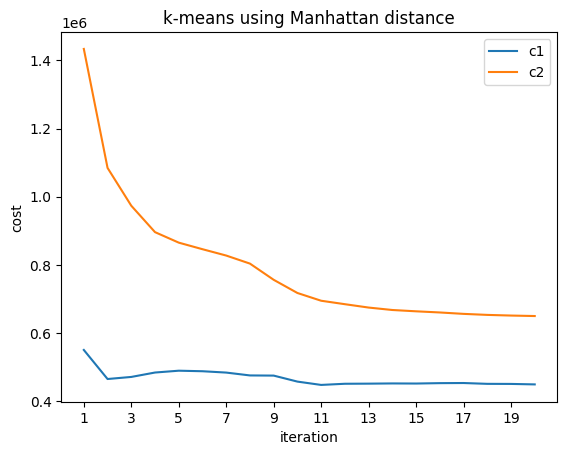

In [8]:
# Plot the results for k-means using Manhattan distance for both c1 and c2 clusters
plt.figure()
plt.plot(list(range(1, 21)), np.array(errorCluster1Manhattan), label = 'c1')
plt.plot(list(range(1, 21)), np.array(errorCluster2Manhattan), label = 'c2')
plt.xticks(list(range(1, 21, 2)))
plt.xlabel('iteration')
plt.ylabel('cost')
plt.legend(['c1', 'c2'])
plt.title('k-means using Manhattan distance')
plt.show()

Percentage improvement values and your explanation for 1(b).

In [9]:
# Print the percentage change in errors for both clusters
percentageChangeCluster1Manhattan = (errorCluster1Manhattan[0] - errorCluster1Manhattan[10]) / errorCluster1Manhattan[0]
percentageChangeCluster2Manhattan = (errorCluster2Manhattan[0] - errorCluster2Manhattan[10]) / errorCluster2Manhattan[0]
print("The percentage change in c1 by using Manhattan distance is: {}".format(percentageChangeCluster1Manhattan))
print("The percentage change in c2 by using Manhattan distance is: {}".format(percentageChangeCluster2Manhattan))

The percentage change in c1 by using Manhattan distance is: 0.18654926116799248
The percentage change in c2 by using Manhattan distance is: 0.5155409910238924
